In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from test_utils import (preprocess_true_boxes,
                        image_preporcess, parse_annotation, load_annotations,get_anchors,
                        convert_to_corners
                        )
###############################################################################
#   Demonstration of what preprocess_true_boxes does
#   1  Take true bounding boxes(bboxes) and class_ids
#   2. compute best anchor boxes, which mask objects the best in the image
#      and store the positions of those anchor boxes in y_true for each grid
#      (y_true will be fed into training later)
#   3. Display anchor boxes and true bounding boxes at the end
#

num_classes = 10 # for mnist dataset : 80 for ms-coco dataset
annos_path = 'test_images/000001.txt'
annos = load_annotations(annos_path)
print('annotations =', annos)
anno = annos[0]
image, true_boxes = parse_annotation(anno)
batch_images = np.array([image]) # (num_batch_images, input_shape, num__channels)
# preprocess_true_boxes takes
# the shape (num_batch_images, num_true_boxes,4+1),
# where 4+1 corresponds to (xmin,ymin,xmax,ymax)+class_id
batch_true_boxes = np.array([true_boxes])
print(batch_images.shape)
print(batch_true_boxes.shape)
print(batch_true_boxes)


annotations = ['E:\\keras_yolob\\test_images\\000001.jpg 226,251,248,273,6 150,36,195,110,1']
(1, 416, 416, 3)
(1, 2, 5)
[[[226 251 248 273   6]
  [150  36 195 110   1]]]


In [10]:
input_shape = image.shape[:2] #[416, 416]
anchors = get_anchors()
y_true, ious, best_anchors = preprocess_true_boxes(batch_true_boxes, input_shape, anchors, num_classes)
y_true13, y_true26,  y_true52 = y_true
print('indices for best_anchors =', best_anchors) # indices for best iou values
print('best_IOU_values =', ious[np.arange(2), best_anchors])
print(y_true13.shape) # 13x13 grid
print(y_true26.shape) # 26x26 grid
print(y_true52.shape) # 52x52 grid


true_boxes.shape = (1, 2, 5)
indices for best_anchors = [2 3]
best_IOU_values = [0.6376812 0.5495495]
(1, 13, 13, 3, 15)
(1, 26, 26, 3, 15)
(1, 52, 52, 3, 15)


In [11]:
#-----------------------------------------------------
#   Bounding Box in xc,yc,w,h 
#
# y_true[L][b,j,i,k,:].shape = (15,)
# 15: 4(xcycwh) + 1(objectness) + 10(num_classes)
# 1. normalized xcycwh by 416
# 2. class_id encoded as one-hot vector for mnist dataset
#
# anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
# anchor_mask[L=1] = [3,4,5]

L=1 # 26x26 grid in 416x416
b=0; i,j = 10, 4 ; k=0 #<- n = 3 ; c=1: mnist digit
print('y_true26 =', y_true[L][b,j,i,k,:])
print('y_true26 scaled box =', y_true[L][b,j,i,k,0:4])
box1 = y_true[L][b,j,i,k,0:4]*416.0 #scaling back
print('y_true26 box =', box1) # xc,yc,w,h format

L=2 # 52x52 grid in 416x416
b=0; i,j = 29,32 ; k=2 #<- n = 2 ; c=6: mnist digit
                       #k=2 of L=2 : 
print('y_true52 =', y_true[L][b,j,i,k,:])
print('y_true52 scaled box =', y_true[L][b,j,i,k,0:4])
box2 = y_true[L][b,j,i,k,0:4]*416.0  #scaling back
print('y_true52 box =', box2) # xc,yc,w,h format

y_true26 = [0.41346154 0.17548077 0.10817308 0.17788461 1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
y_true26 scaled box = [0.41346154 0.17548077 0.10817308 0.17788461]
y_true26 box = [172.  73.  45.  74.]
y_true52 = [0.56971157 0.6298077  0.05288462 0.05288462 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.        ]
y_true52 scaled box = [0.56971157 0.6298077  0.05288462 0.05288462]
y_true52 box = [237.00002 262.       22.       22.     ]


boxes_xywh = [[172.       73.       45.       74.     ]
 [237.00002 262.       22.       22.     ]]
box = tf.Tensor([149.5  36.  194.5 110. ], shape=(4,), dtype=float32)
box = tf.Tensor([226.00002 251.      248.00002 273.     ], shape=(4,), dtype=float32)


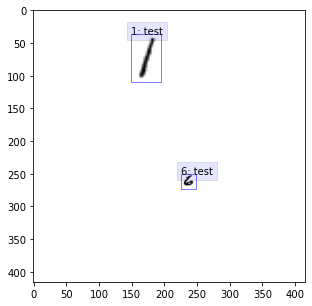

In [12]:
#--------------------------------------------------
#
#   Display an image of objects and bboxes
#

boxes_xywh = np.array([box1,box2]) # box1 and box2 are in [xc,yc,w,h] format
print('boxes_xywh =', boxes_xywh)
boxes_xyxy = convert_to_corners(boxes_xywh) # [xmin,ymin,xmax,ymax] format
classes = [1, 6] # from true_boxes[b, t, 4].astype('int32')
scores = ['test', 'test']
#image = np.array(image, dtype=np.uint8)
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.imshow(image)
ax = plt.gca() ; color=[0, 0, 1]
for box, _cls, score in zip(boxes_xyxy, classes, scores):
    #text = "{}: {:.2f}".format(_cls, score)
    text = "{}: {:}".format(_cls, score)
    print('box =', box)  # =
    x1, y1, x2, y2 = box # box in format [xmin,ymin,xmax,ymax]
    w, h = abs(x2-x1), abs(y2-y1)
    patch = plt.Rectangle([x1, y1], w, h, fill=False,
                          edgecolor=color, linewidth=0.5)
    ax.add_patch(patch)
    ax.text( x1, y1, text,  bbox={"facecolor": color, "alpha": 0.1},
             clip_box=ax.clipbox, clip_on=True, )


box = tf.Tensor([149.5  36.  194.5 110. ], shape=(4,), dtype=float32)
box = tf.Tensor([226.00002 251.      248.00002 273.     ], shape=(4,), dtype=float32)
red dot : center of the anchor box
168.0 72.0


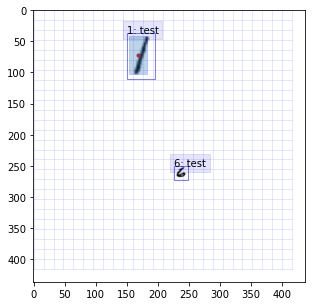

In [13]:
#---------------------------------------------------
#  Anchor Box and Grid
#
classes = [1, 6] # from true_boxes[b, t, 4].astype('int32')
scores = ['test', 'test']
#image = np.array(image, dtype=np.uint8)
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.imshow(image)
ax = plt.gca() ; color=[0, 0, 1]
for box, _cls, score in zip(boxes_xyxy, classes, scores):
    #text = "{}: {:.2f}".format(_cls, score)
    text = "{}: {:}".format(_cls, score)
    print('box =', box)  # =
    x1, y1, x2, y2 = box # box in format [xmin,ymin,xmax,ymax]
    w, h = abs(x2-x1), abs(y2-y1)
    patch = plt.Rectangle([x1, y1], w, h, fill=False,
                          edgecolor=color, linewidth=0.5)
    ax.add_patch(patch)
    ax.text( x1, y1, text,  bbox={"facecolor": color, "alpha": 0.1},
             clip_box=ax.clipbox, clip_on=True, )

######### 26x26 grid
grid = 26  # L = 1 n = 3
i, j = 10, 4# position of anchor
x = np.linspace(0,416,grid+1) # start, end, howmany
y = np.linspace(0,416,grid+1)
xx, yy = np.meshgrid(x,y)
anchor_xc = xx[i+1, i+1] - x[1]/2.0
anchor_yc = yy[j+1, 0] - y[1]/2.0
print('red dot : center of the anchor box')
print(anchor_xc, anchor_yc)
plt.scatter(anchor_xc, anchor_yc, marker='.', color='r')
plt.plot(xx, yy, 'b', linewidth=0.5, alpha=0.2)
plt.plot(yy, xx, 'b', linewidth=0.5, alpha=0.2)

# Anchor box; width and height
L = 1; n = 3
anchor = anchors[n]
w, h = anchor
xmin = anchor_xc - w/2.0
ymin = anchor_yc - h/2.0
anchor_patch = plt.Rectangle([xmin, ymin], w, h, fill=True, alpha=0.3, 
                              edgecolor=color, linewidth=0.5)
ax.add_patch(anchor_patch)
plt.show()


box = tf.Tensor([149.5  36.  194.5 110. ], shape=(4,), dtype=float32)
box = tf.Tensor([226.00002 251.      248.00002 273.     ], shape=(4,), dtype=float32)
red dot : center of the anchor box
236.0 260.0


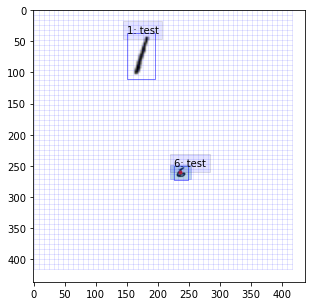

In [26]:
classes = [1, 6] # from true_boxes[b, t, 4].astype('int32')
scores = ['test', 'test']
#image = np.array(image, dtype=np.uint8)
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.imshow(image)
ax = plt.gca() ; color=[0, 0, 1]
for box, _cls, score in zip(boxes_xyxy, classes, scores):
    #text = "{}: {:.2f}".format(_cls, score)
    text = "{}: {:}".format(_cls, score)
    print('box =', box)  # =
    x1, y1, x2, y2 = box # box in format [xmin,ymin,xmax,ymax]
    w, h = abs(x2-x1), abs(y2-y1)
    patch = plt.Rectangle([x1, y1], w, h, fill=False,
                          edgecolor=color, linewidth=0.5)
    ax.add_patch(patch)
    ax.text( x1, y1, text,  bbox={"facecolor": color, "alpha": 0.1},
             clip_box=ax.clipbox, clip_on=True, )

####### 52x52 grid            
grid = 52  # L = 2 n = 2
i,j = 29,32# position of anchor
x = np.linspace(0,416,grid+1) # start, end, howmany
y = np.linspace(0,416,grid+1)
xx, yy = np.meshgrid(x,y)
anchor_xc = xx[i+1, i+1]- x[1]/2.0
anchor_yc = yy[j+1,0] - y[1]/2.0
print('red dot : center of the anchor box')
print(anchor_xc, anchor_yc)
plt.scatter(anchor_xc, anchor_yc, marker='.', color='r')
plt.plot(xx, yy, 'b', linewidth=0.5, alpha=0.2)
plt.plot(yy, xx, 'b', linewidth=0.5, alpha=0.2)

# Anchor box width and height
L = 2; n = 2
anchor = anchors[n]
w, h = anchor
xmin = anchor_xc - w/2.0
ymin = anchor_yc - h/2.0
anchor_patch = plt.Rectangle([xmin, ymin], w, h, fill=True, alpha=0.3, 
                          edgecolor=color, linewidth=0.5)
ax.add_patch(anchor_patch)
plt.show()
